# Surface temperature - Future scenarios

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray
import dask

dask.config.set(scheduler="processes")

# Temperature

## Load the ESGF Virtual Aggregation inventory

Load the CSV inventory and locate the datasets of interest (refer to the [tutorial]() for further information).

In [2]:
df = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")

subset = pd.concat([
    df.query("model == 'CNRM-CM6-1' & product == 'ScenarioMIP' & experiment == 'ssp126' & variable == 'tas' & institution == 'CNRM-CERFACS' & table == 'Amon' & replica == 'esgf.ceda.ac.uk' & version == 'v20190410'"),
    df.query("model == 'CNRM-CM6-1' & product == 'ScenarioMIP' & experiment == 'ssp245' & variable == 'tas' & institution == 'CNRM-CERFACS' & table == 'Amon' & replica == 'esgf.ceda.ac.uk' & version == 'v20190410'"),
    df.query("model == 'CNRM-CM6-1' & product == 'ScenarioMIP' & experiment == 'ssp370' & variable == 'tas' & institution == 'CNRM-CERFACS' & table == 'Amon' & replica == 'esgf.ceda.ac.uk' & version == 'v20190410'"),
    df.query("model == 'CNRM-CM6-1' & product == 'ScenarioMIP' & experiment == 'ssp585' & variable == 'tas' & institution == 'CNRM-CERFACS' & table == 'Amon' & replica == 'esgf.ceda.ac.uk' & version == 'v20190410'"),
    df.query("model == 'CNRM-CM6-1' & product == 'CMIP' & experiment == 'historical' & variable == 'tas' & institution == 'CNRM-CERFACS' & table == 'Amon' & replica == 'esgf.ceda.ac.uk' & version == 'v20190125'"),
]).set_index("experiment")

subset

/tmp/ipykernel_123225/3758303378.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")


,location,project,product,institution,model,subexperiment,table,variable,grid_label,version,replica
experiment,,,,,,,,,,,
ssp126,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1,NaN,Amon,tas,gr,v20190410,esgf.ceda.ac.uk
ssp245,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1,NaN,Amon,tas,gr,v20190410,esgf.ceda.ac.uk
ssp370,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1,NaN,Amon,tas,gr,v20190410,esgf.ceda.ac.uk
ssp585,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1,NaN,Amon,tas,gr,v20190410,esgf.ceda.ac.uk
historical,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,NaN,Amon,tas,gr,v20190125,esgf.ceda.ac.uk


## 5 model members (19 for historical)

In [3]:
%%time

ssp126 = xarray.open_dataset(subset.loc["ssp126", "location"]).chunk(variant_label=1, time=100)
ssp245 = xarray.open_dataset(subset.loc["ssp245", "location"]).chunk(variant_label=1, time=100)
ssp370 = xarray.open_dataset(subset.loc["ssp370", "location"]).chunk(variant_label=1, time=100)
ssp585 = xarray.open_dataset(subset.loc["ssp585", "location"]).chunk(variant_label=1, time=100)

historical = xarray.open_dataset(subset.loc["historical", "location"]).chunk(variant_label=1, time=100)
scenarios = xarray.concat([ssp126, ssp245, ssp370, ssp585], dim=xarray.Variable(["scenario"], ["ssp126", "ssp245", "ssp370", "ssp585"]))

CPU times: user 327 ms, sys: 25.9 ms, total: 353 ms
Wall time: 2.02 s


In [4]:
%%time

weights = np.cos(np.deg2rad(scenarios["lat"]))
mean_hist_1995_2014 = historical["tas"].sel(time=slice("19950101", "20141231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_worker=4)

historical_mean = historical["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)
scenarios_mean = scenarios["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)

historical_mean_spatial = historical["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)
scenarios_mean_spatial = scenarios["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)

q = scenarios_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])

CPU times: user 17.4 s, sys: 19.9 s, total: 37.3 s
Wall time: 6min 23s


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be

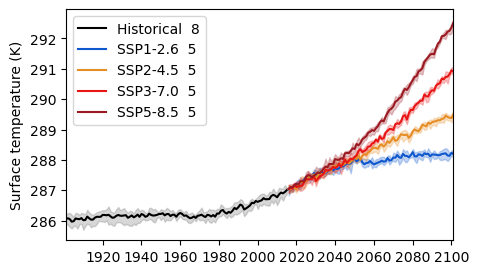

In [5]:
fig, ax = plt.subplots(figsize=(5,3))

colors = {
    "ssp126": "#0e57cc",
    "ssp245": "#e68d26",
    "ssp370": "#e81515",
    "ssp585": "#9b1a22",
}

labels = {
    "ssp126": "SSP1-2.6",
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp585": "SSP5-8.5",
}

lengths = {
    "ssp126": len(ssp126["variant_label"]),
    "ssp245": len(ssp245["variant_label"]),
    "ssp370": len(ssp370["variant_label"]),
    "ssp585": len(ssp585["variant_label"]),
}

qh = historical_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])
ax.plot(
    historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)).time,
    historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)),
    color="black",
    label=f"Historical  {len(historical['variant_label'])}")
ax.fill_between(
    qh.sel(time=slice("19000101", None)).time,
    qh.sel(time=slice("19000101", None)).sel(quantile=.05),
    qh.sel(time=slice("19000101", None)).sel(quantile=.95),
    color="#616161", alpha=.25)

for scenario_da in scenarios["scenario"]:
    sc = scenario_da.item()
    ax.plot(
        scenarios_mean.sel(scenario=sc).resample(time="Y").mean().time,
        scenarios_mean.sel(scenario=sc).resample(time="Y").mean(),
        color=colors[sc],
        label=f"{labels[sc]}  {lengths[sc]}")
    ax.fill_between(
        q.time,
        q.sel(scenario=sc, quantile=.05),
        q.sel(scenario=sc, quantile=.95),
        color=colors[sc], alpha=.25)

ax.set_ylabel("Surface temperature (K)")
ax.legend()

plt.margins(x=0)
plt.savefig("scenarios-tas-CNRM-CM6-1.pdf")